> ## Question 6
>The CSV “all_pitches.csv” (see Google drive link below) contains fastballs and sliders thrown by LHP vs. LHH in MLB.  
>
>Build a pitch grading algorithm that assesses the quality of each individual pitch (independent of its results).  
>
>Your response should include:
A description of your methodology, model selection, and validation.
A summary of your results including an assessment of the success rate of your model
all_pitches.csv: https://drive.google.com/file/d/18nQluzVuTQw-i8t6do9MhNhCHDEKLwt6/view?usp=sharing
>
>Your submission should include (please attach in question #7):
Any code used to perform this research
Charts or tables that you would use to help communicate your findings.

### Overview
We are asked to build a pitch grading algorithm to asses each individual pitch's quality. 

This can be broken up in to two main steps: classification --- which determines the relative level of the pitch grade; and model building --- which quantifies good vs. bad.

The problem can be approached with increasing levels of sophistication, but should always begin with the simplest approach.  
In this case, a simple Logistic Regression based on \texttt{pitch_call} is a reasonable choice.  

### Strategy
1. Inspect, clean, and organize data.  
2. Look for collinearity and crop data.
3. Find model coefficients from Logistic Regression.
4. Build rubrick to classify quality of pitch. 

In [10]:
# Import Python Libraries that form backbone of analysis 
import pdb                      # debugger
import numpy as np              # numpy for scientific computing
import pandas as pd             # pandas for dataframes
import scipy as sp              # scipy for techincal computing
import matplotlib.pyplot as plt # matplotlib for plotting
import matplotlib

%matplotlib inline

plt.style.use('ggplot')

Read data into pandas dataframe

In [3]:
path_data = './'
file_pitchers = 'all_pitches_trackman.csv'
pitchers_data = pd.read_csv(path_data + file_pitchers)
print(""" Number of pitches = {0} """.format(len(pitchers_data)))

 Number of pitches = 98559 


/Users/marcoviero/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Clean NaNs and inspect dataframe

In [4]:
indnn = pitchers_data.rel_speed.notnull()
pitchers_data.head()

,pitch_uid,pitch_type,pitch_call,play_result,rel_speed,spin_rate,spin_axis,rel_height,rel_side,extension,induced_vert_break,horz_break,plate_loc_height,plate_loc_side,vert_appr_angle,horz_appr_angle
0,848bce5d-2968-4ba9-a8d1-71e485821416,FB,StrikeSwinging,Undefined,92.614932,2062.363369,158.189582,6.657738,-1.934755,5.886618,17.054645,-6.835823,2.647593,0.109630,-5.817452,1.529552
1,39601156-09a5-417f-a6fe-cf9e969b0035,FB,BallCalled,Undefined,93.505779,2074.372290,145.191262,6.452201,-0.676566,5.902529,5.928455,-4.140085,0.884391,0.282608,-8.449087,0.629116
2,55fefc05-6955-4674-988e-17f31f28c5a4,FB,BallCalled,Undefined,93.434940,2167.853571,148.231700,5.915799,-1.583470,6.140743,16.447586,-10.201667,0.864483,1.052220,-6.918216,1.850025
3,743ba583-f1ce-4cc4-a103-34f6a2ee22d3,SL,InPlay,Out,78.736644,2386.768650,259.898029,6.256930,-1.813793,5.293332,2.796726,15.913225,2.390938,1.280305,-8.259049,4.839435
4,bd6be3ed-c225-4eb2-8526-f8d9ad2cc85b,SL,FoulBall,Undefined,78.430132,2435.990635,250.780912,6.336123,-1.685950,5.731613,4.291393,12.418729,3.081289,-0.105870,-7.482266,2.913148


In [26]:
clean_pitch_data = pitchers_data[indnn][['pitch_call','pitch_type','rel_speed', 'spin_rate', 'spin_axis', 'rel_height', 'rel_side', 'extension', 'induced_vert_break', 'horz_break', 'plate_loc_height','plate_loc_side']]

Visualize pitch locations

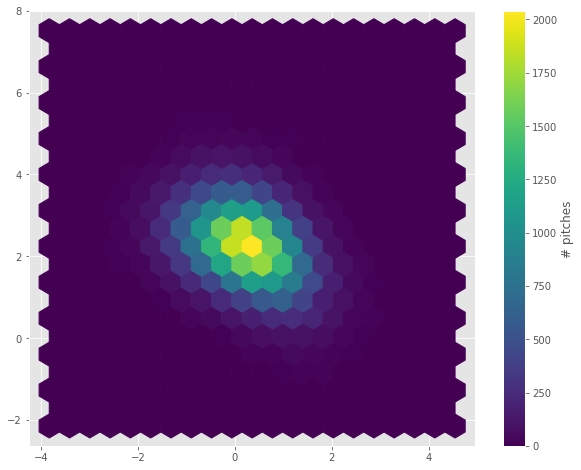

In [5]:
fig, ax = plt.subplots(figsize=(10,8))
im = ax.hexbin(pitchers_data.plate_loc_side.dropna(), pitchers_data.plate_loc_height.dropna(), gridsize=20)
fig.colorbar(im, ax=ax, label = '# pitches')

Check for collinearity

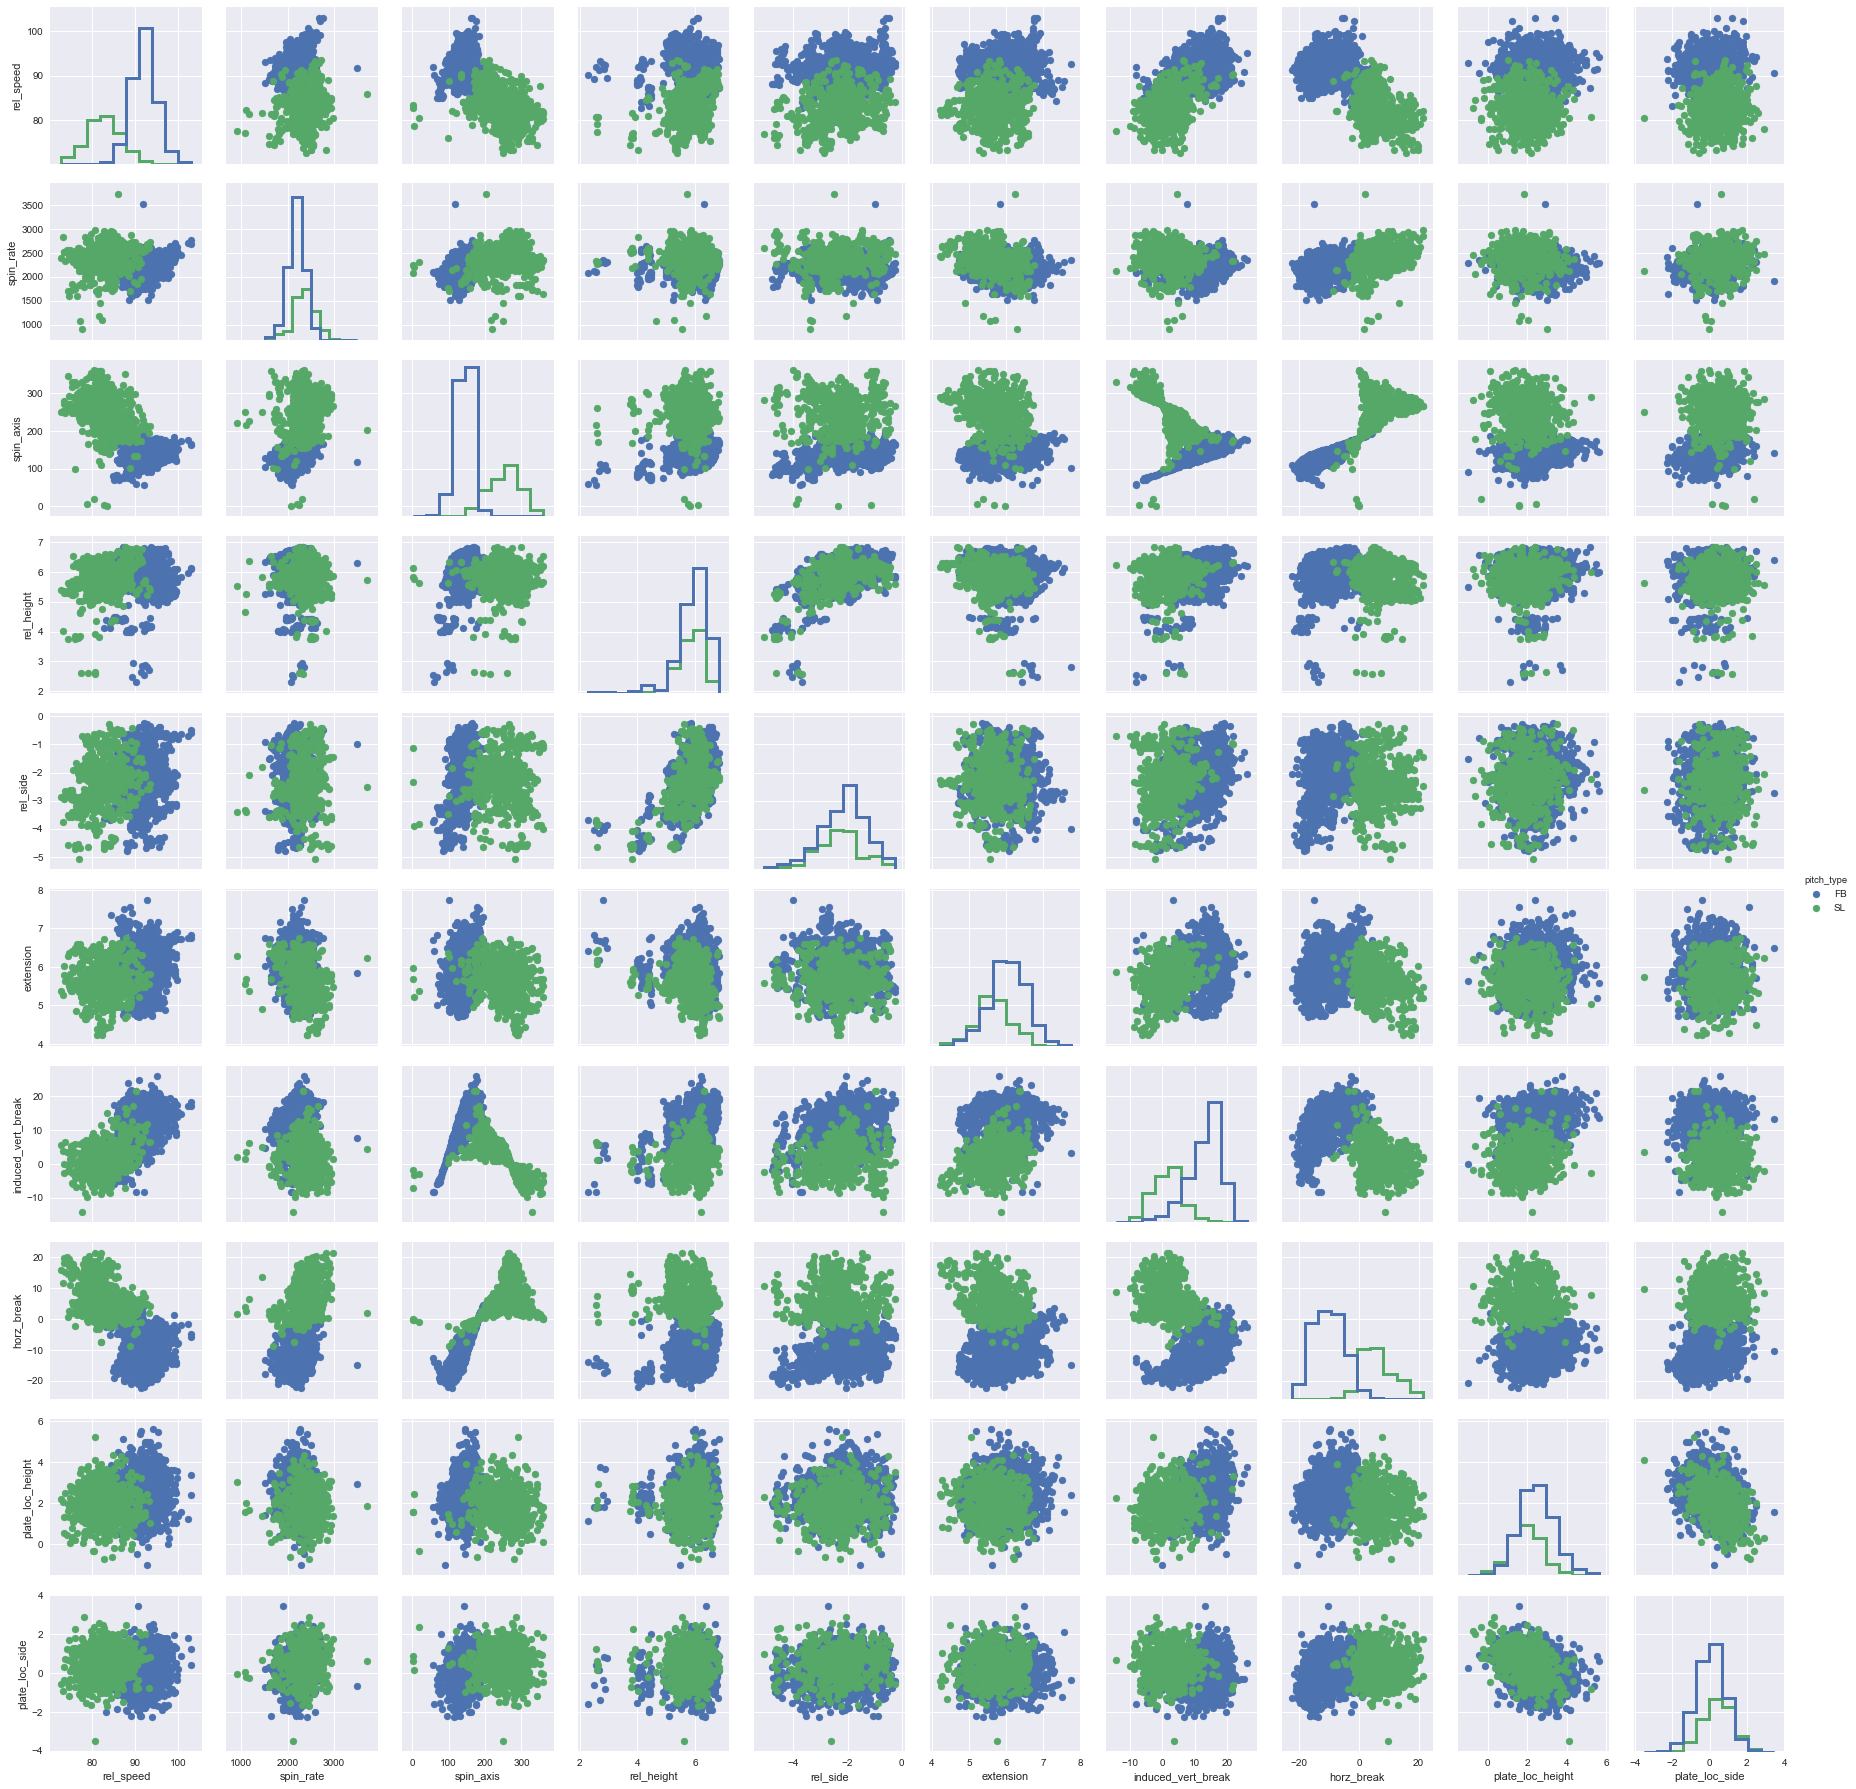

In [270]:
npitches = 2000
g = sns.PairGrid(pitchers_data[indnn][0:npitches], hue="pitch_type", 
                 vars = ['rel_speed', 'spin_rate', 'spin_axis', 'rel_height', 'rel_side',
                         'extension', 'induced_vert_break', 'horz_break', 'plate_loc_height',
                         'plate_loc_side']) 
g = g.map_diag(plt.hist, histtype="step", linewidth=3)
g = g.map_offdiag(plt.scatter)
g = g.add_legend()

Categorize the different pitch calls.  To simplify model, group strikes, in play, and balls into 3 categories

In [27]:
pitch_calls = np.unique(clean_pitch_data['pitch_call'])
strike, y = is_inside_ellipsoid(pitchers_data[indnn].plate_loc_side, pitchers_data[indnn].plate_loc_height)
clean_pitch_data['pitch_class'] = np.zeros(len(clean_pitch_data))
for ipitch in range(len(pitch_calls)):
    ind_pitch = clean_pitch_data['pitch_call'] == pitch_calls[ipitch]
    if (pitch_calls[ipitch] == 'FoulBall') | (pitch_calls[ipitch] == 'StrikeCalled') | (pitch_calls[ipitch] == 'StrikeSwinging'):
        clean_pitch_data['pitch_class'][ind_pitch] = 1
        print 1, pitch_calls[ipitch]
    elif (pitch_calls[ipitch] == 'HitByPitch') | (pitch_calls[ipitch] == 'InPlay'):
        clean_pitch_data['pitch_class'][ind_pitch] = 2
        print 2, pitch_calls[ipitch]
    else:
        clean_pitch_data['pitch_class'][ind_pitch] = 0
        print 0, pitch_calls[ipitch]

['BallCalled' 'FoulBall' 'HitByPitch' 'InPlay' 'StrikeCalled'
 'StrikeSwinging']
0 BallCalled


/Users/marcoviero/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/marcoviero/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/marcoviero/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


1 FoulBall
2 HitByPitch
2 InPlay
1 StrikeCalled
1 StrikeSwinging


### Split data into test and train for cross validation

In [66]:
from sklearn.cross_validation import train_test_split

Y = clean_pitch_data.pitch_class.values
df_train,df_test,Y_train,Y_test = train_test_split(clean_pitch_data,Y, test_size=0.25)

In [67]:
from patsy import dmatrices

Y_train, X_train = dmatrices('pitch_class ~ pitch_type + rel_speed + spin_rate + induced_vert_break + horz_break +plate_loc_height+plate_loc_side', df_train, return_type="dataframe")
Y_test, X_test = dmatrices('pitch_class ~ pitch_type + rel_speed + spin_rate + induced_vert_break + horz_break +plate_loc_height+plate_loc_side', df_test, return_type="dataframe")

### Instantiate LogisticRegression model and fit with X and y

In [68]:

from sklearn.linear_model import LinearRegression, LogisticRegression 

LGR = LogisticRegression(solver='newton-cg',multi_class='multinomial')
model = LGR.fit(X_train, Y_train)
Y_pred = LGR.predict(X_test)

# check the accuracy on the training set
print 'Model Score (1 is perfect) = '+ "%0.2f" % model.score(X_test, Y_test)

Model Score (1 is perfect) = 0.60


/Users/marcoviero/anaconda/lib/python2.7/site-packages/scipy/optimize/linesearch.py:421: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)


### Model Quality of Pitch

In [69]:
def pitch_grade_estimator(pitch_values, model, weights = [-.1, 0.8, -0.7]):   
    w = np.dot(model.coef_ , pitch_values.T)
    return np.sum(w.T * weights,axis=1)

In [78]:
pitch_grades = pitch_grade_estimator(X_test, model)